In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [5]:
from torch.autograd import Variable

# Experiments on MNIST

Clustered FL datasets are created based on the MNIST datasets. In order to simulate a federated setting that local datasets are from different distributions, data are augmented by using rotation, firstly augment the dataset by applying 0,45 degrees of rotation to the images, and then generate a graph with 2 clusters, each cluster has 10 nodes. To formulate a binary problem, currently only images for digit 3 and 8 are included,as they are most difficult to distinguish from each other.  10000 0-degree rotated images are randomly partitioned into the 10 nodes of cluster1,and 10000 45-degree rotated images are randomly partitioned into the 10 nodes of cluster2 ,so that each node holds 1000 images with the same rotation i.e. assumed to be from i.i.d 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


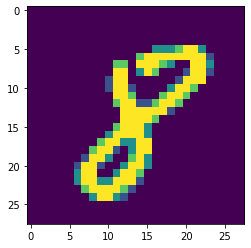

In [6]:
mnist = pd.read_csv('mnist_train.csv')        #read in original dataset from csv

data = mnist[mnist.label.isin([3,8])]         #include digit 3 and 8 as they are most difficult to distinguish

new_label = [0 if i== 3 else 1 for i in data.label.values]

data['label']=new_label

plt.imshow(data.iloc[70,1:].values.reshape(28,28))

In [7]:
# Augment the dataset by using 45 degree rotation
data_r = np.zeros(data.shape)
from scipy.ndimage import rotate
data_r = np.zeros(data.shape)
for i in range(data.shape[0]):
    r = rotate(data.iloc[i,1:].values.reshape(28,28), angle=45,reshape=False).ravel()
    l = np.array([data.iloc[i,0]])
    data_r[i] = np.concatenate((l,r))

data_r = pd.DataFrame(data=data_r,columns=data.columns)

## define models, optimizers, penalties, help functions

In [76]:
import torch
import abc
import torch.nn.functional as F

from abc import ABC


# The linear model which implemented by pytorch
class TorchLogModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLogModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
    
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLogOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters())
        super(TorchLogOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.norm(self.model.linear.weight - torch_old_weight) **2 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()

In [74]:
a = np.arange(3*4*5).reshape((3,4,5))
b = np.arange(3*4*5)[::-1].reshape((4,5,3))
np.dot(a, b)[2,3,2,1]
#[2,3,2,1,2,2]




sum(a[2,3,:] * b[2,:,1])

a

6240

In [12]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


In [13]:
from torch.autograd import Variable
from graspy.simulations import sbm


def get_B_weight_vec(num_nodes,num_edges):
    '''
    :param num_nodes: number of nodes
    :param num_edges: number of edges
    
    :return B: incidence matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    '''
   
    N = num_nodes
    E = num_edges
    '''
    N: total number of nodes
    E: total number of edges
    '''
        
    # create B(incidence matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: incidence matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i in range(N):
        for j in range(N):
            if i >= j:
                continue
            B[cnt, i] = 1
            B[cnt, j] = -1

            weight_vec[cnt] = 0.01
            cnt += 1
    
    return B, weight_vec

In [14]:
def total_loss(datapoints,new_w,new_B,new_weight_vec):
#    
#    Total loss of the graph structure learning algorithm
#   
    loss=0
    N = new_w.shape[0]
    
    for i in range(N):
        y = datapoints[i]['label']
        model = datapoints[i]['model']
        model.linear.weight.data = torch.from_numpy(np.array(new_w[i], dtype=np.float32))

        y_pred = model(datapoints[i]['features'])
        criterion = torch.nn.MSELoss(reduction='mean')
        
        loss += criterion(y,y_pred)
    loss = loss+np.dot(new_weight_vec,np.linalg.norm(new_B.dot(new_w),ord=1,axis=1))
    return loss

## Main Algorithms
algorithms for structure learning and model training

In [15]:
def learn_graph_structure(K1,K2, graph,learning_rate, lambda_lasso=1, penalty_func_name='norm1', get_loss=False):
    '''
    The algorithm to learn datasets relationships.
    Inputs
        K1: out iteration numbers
        K2: inner iteration numbers
        graph: graph with node attributes setted up
    Outputs:
        new_weight_vec: updated dual variable which represents the distance between local model parameters
        Loss: iteration loss
    '''
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    B, weight_vec = get_B_weight_vec(num_nodes,num_edges)
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
    '''
    shape of the graph
    '''
    m, n = graph.nodes[1]['features'].shape
    '''
    shape of the feature vectors of each node in the graph, i.e. m is the number of samples, 
    n is the dimension of features
    '''

    new_w = np.array([np.zeros(n) for i in range(N)])
    
    new_u = np.array([np.zeros(n) for i in range(E)])
    new_weight_vec = weight_vec
    
    
    Loss = {}
    iteration_scores = []
    for j in range(K1):
        
        new_B = np.dot(np.diag(new_weight_vec),B)
        T_matrix = np.diag(np.array((1 / (np.sum(abs(B), 0)))).ravel())
        T = np.array((1 / (np.sum(abs(B), 0)))).ravel()
        
        
        for iterk in range(K2):
            prev_w = np.copy(new_w)

            hat_w = new_w - np.dot(T_matrix, np.dot(new_B.T, new_u))


            for i in range(N):
                optimizer = graph.nodes[i]['optimizer']
                new_w[i] = optimizer.optimize(graph.nodes[i]['features'],graph.nodes[i]['label'], hat_w[i],T[i])

            tilde_w = 2 * new_w - prev_w
            new_u = new_u + np.dot(Sigma, np.dot(new_B, tilde_w))

            penalty_func = Norm1Pelanty(lambda_lasso, new_weight_vec, Sigma, n)
            new_u = penalty_func.update(new_u)
        new_weight_vec = new_weight_vec +learning_rate*np.linalg.norm(np.dot(B, new_w),ord=1,axis=1)
        if get_loss==True:
            Loss[j] = total_loss(graph.nodes,new_w,new_B,new_weight_vec)

    return new_weight_vec,Loss

In [16]:

from sklearn.metrics import mean_squared_error


def algorithm_1(K,graph,lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param graph: a graph with node attributes and edge attributes setted up
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''
    
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    D = np.zeros((num_edges,num_nodes))
    for i,e in enumerate(graph.edges):
        D[i,e[0]]=1
        D[i,e[1]]=-1
    weight_vec = np.array(list(nx.get_edge_attributes(graph,'weight').values()))
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array(1.0 / (np.sum(abs(D), 0))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''
    T = np.array(1.0 / ((np.sum(abs(D), 0)))).ravel()

  
    E, N = D.shape
    m, n = graph.nodes[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)

        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))
        for i in range(N):
                optimizer = graph.nodes[i]['optimizer']
                new_w[i] = optimizer.optimize(graph.nodes[i]['features'],   
                                              graph.nodes[i]['label'], 
                                              hat_w[i],T[i])

        
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(graph.nodes[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


## Generate local datasets from the csv file


To simulate the fact that the amount of training data is usually insufficient, we randomly selected 100 datapoints as training data for each local datatset.The left datapoints will be used for test.

In [17]:
from sklearn.preprocessing import MinMaxScaler
def generate_datapoints(data,data_r):
    '''
    Input
       datasets: dataframes storing all datasets
    Output
       datapoints: a dictionary containing the attributes for each node in the graph,
       which are features, label, model, and also the optimizer for each node
    '''
    data = data.sample(frac=1,replace=True).reset_index(drop=True)  #shuffle the dataset
    data_r = data_r.sample(frac=1,replace=True).reset_index(drop=True)  #shuffle the dataset
    datapoints = {}
    for i in range(20): 
        if i < 10:
            features = data.iloc[i*1000:(i+1)*1000,1:].values/255
            labels = data.iloc[i*1000:(i+1)*1000,0].values
            
        else:
            features = data_r.iloc[(i-10)*1000:(i-9)*1000,1:].values/255
            labels = data_r.iloc[(i-10)*1000:(i-9)*1000,0].values
        n = features.shape[1]

        model = TorchLogModel(n)
        '''
        model : the logistic model for the node i that is implemented by pytorch
        '''
        optimizer = TorchLogOptimizer(model)
        '''
        optimizer : the optimizer model for the node i that is implemented by pytorch with BCE loss function
        '''

        datapoints[i] = {
            'features': Variable(torch.from_numpy(features[:100,:])).to(torch.float32),
            'model': model,
            'label': Variable(torch.from_numpy(labels[:100])).to(torch.float32),
            'optimizer': optimizer,
            'features_val': Variable(torch.from_numpy(features[100:150,:])).to(torch.float32),
            'label_val': Variable(torch.from_numpy(labels[100:150])).to(torch.float32),
            'features_test': Variable(torch.from_numpy(features[150:,:])).to(torch.float32),
            'label_test': Variable(torch.from_numpy(labels[150:])).to(torch.float32)
        }
        
    return datapoints

In [64]:
# generate datapoints dict which will be used to set node attributes for the graph
datapoints = generate_datapoints(data,data_r)

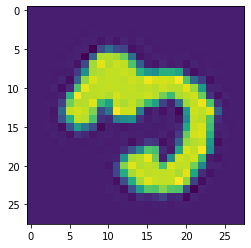

In [65]:
plt.imshow(datapoints[18]['features'][0,:].reshape(28,28))  # this is 45 degree rotated

In [66]:
g = nx.complete_graph(20)             # we assume a fully connected graph initially
nx.set_node_attributes(g,datapoints)  # set up the graph with a dictionary datapoints generated from raw datasets

## run experiments

### datasets relationships
#### learn relations via dual-ascent 

 <p style="color:darkblue; font-size:20px">?? The problem is how to choose learning rate (step size)?</p>
 
 
As I already know the intrinsic structure of the graph, so I know which learning rate is the optimal, but for unknown graph, this is a problem, my current sense is that the when the learned dual variable value is between 0-2, it feels right. and also it's important to normalize or standardize input data in advance.

In [67]:
# Learn dual variable (node distance) from graph with nodes attributes already setted up
new_weight_vec,_ = learn_graph_structure(K1=20,K2=300,graph=g,learning_rate=0.005)  

In [68]:
# generate three edge index lists: intral cluster edges and inter cluster edges
ind_cluster1 = []
ind_cluster2 = []
ind_inter_clusters = []
for i,e in enumerate(g.edges):
    if e[0]<10 and e[1]<10:
        ind_cluster1.append(i)
    
    elif e[0]<10 and e[1]>=10:
        ind_inter_clusters.append(i)
    else:
        ind_cluster2.append(i)  

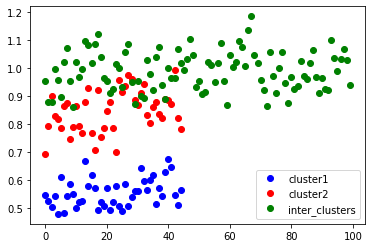

In [69]:
# visulize learned node distance, we can see inter cluster nodes distances are largest
plt.plot(new_weight_vec[ind_cluster1],'bo',label='cluster1')  
plt.plot(new_weight_vec[ind_cluster2],'ro',label='cluster2')  
plt.plot(new_weight_vec[ind_inter_clusters],'go',label='inter_clusters')  
plt.legend()

In [70]:
# generate edge weights from the learned dual variable
learned_weight_vec = np.exp(-new_weight_vec/1)

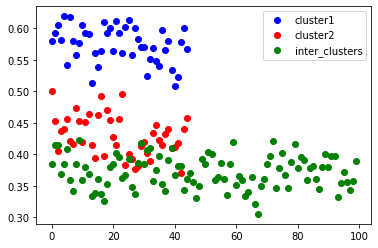

In [71]:
# visulize edge weights, inter cluster weights are smallest
plt.plot(learned_weight_vec[ind_cluster1],'bo',label='cluster1')  
plt.plot(learned_weight_vec[ind_cluster2],'ro',label='cluster2')  
plt.plot(learned_weight_vec[ind_inter_clusters],'go',label='inter_clusters')  
plt.legend()

In [72]:
dic = {i:np.array([0.0,0.0,0.0]) for i in range(20)}
ind = {i:[] for i in range(20)}
# ind = [k for k in range(190)]
for n,(i,j) in enumerate(g.edges):
    if (learned_weight_vec[n]>dic[i]).sum():
        dic[i][np.argmin(dic[i])] = learned_weight_vec[n]
        if len(ind[i])==3:
            ind[i][np.argmin(dic[i])]=(i,j)
        else:
            ind[i].append((i,j))

In [73]:
for n,(i,j) in enumerate(g.edges):
    if (learned_weight_vec[n]>dic[j]).sum():
        dic[j][np.argmin(dic[j])] = learned_weight_vec[n]
        if len(ind[j])==3:
            ind[j][np.argmin(dic[i])]=(i,j)
        else:
            ind[j].append((i,j))
#         ind[j].append((i,j))

In [74]:
ind

{0: [(0, 4), (0, 5), (0, 7)],
 1: [(1, 5), (1, 3), (1, 4)],
 2: [(2, 3), (2, 4), (2, 7)],
 3: [(1, 3), (3, 5), (2, 3)],
 4: [(3, 4), (4, 6), (2, 4)],
 5: [(3, 5), (5, 7), (2, 5)],
 6: [(3, 6), (6, 8), (2, 6)],
 7: [(3, 7), (7, 9), (2, 7)],
 8: [(3, 8), (8, 12), (2, 8)],
 9: [(5, 9), (7, 9), (2, 9)],
 10: [(10, 11), (10, 16), (10, 19)],
 11: [(11, 18), (11, 13), (10, 11)],
 12: [(12, 19), (12, 14), (12, 18)],
 13: [(13, 14), (11, 13), (10, 13)],
 14: [(12, 14), (11, 14), (10, 14)],
 15: [(12, 15), (11, 15), (10, 15)],
 16: [(15, 16), (11, 16), (10, 16)],
 17: [(15, 17), (11, 17), (10, 17)],
 18: [(12, 18), (11, 18), (10, 18)],
 19: [(12, 19), (11, 19), (10, 19)]}

In [75]:
es_kept = []
for val in ind.values():
    for i in range(3):
        if val[i] not in es_kept:
            es_kept.append(val[i])
    

In [76]:
weights_drop = []
for n,e in enumerate(g.edges(data=False)):
    if e not in es_kept:
        weights_drop.append(n)
        g.remove_edge(*e)
weights_drop

[0,
 1,
 2,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 146,
 154,
 162,
 165,
 166,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189]

In [77]:
g.edges

EdgeView([(0, 4), (0, 5), (0, 7), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 6), (5, 7), (5, 9), (6, 8), (7, 9), (8, 12), (10, 11), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (12, 14), (12, 15), (12, 18), (12, 19), (13, 14), (15, 16), (15, 17)])

In [78]:
weights = np.delete(learned_weight_vec,weights_drop)

In [79]:
weigh = {}
for e in g.edges:
    weigh[e] = {'weight':weights[i]}
nx.set_edge_attributes(g,weigh)

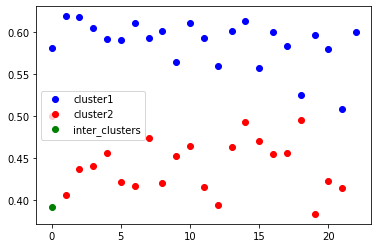

In [80]:
# generate three edge index lists: intral cluster edges and inter cluster edges
ind_cluster1 = []
ind_cluster2 = []
ind_inter_clusters = []
for i,e in enumerate(g.edges):
    if e[0]<10 and e[1]<10:
        ind_cluster1.append(i)
    
    elif e[0]<10 and e[1]>=10:
        ind_inter_clusters.append(i)
    else:
        ind_cluster2.append(i) 
# visulize learned node distance, we can see inter cluster nodes distances are largest
plt.plot(weights[ind_cluster1],'bo',label='cluster1')  
plt.plot(weights[ind_cluster2],'ro',label='cluster2')  
plt.plot(weights[ind_inter_clusters],'go',label='inter_clusters')  
plt.legend()

### learn tailored predictor for each local dataset


In [42]:
# set up graph edge attribute 'weight' by using the learned weight vector
# def update_graph_weight(g,weight_vector,sparse=True,threshold=None):
#     '''
#     Update graph edge attributes.
#     Inputs:
#         graph: graph with node attributes setted up
#         weight_vector: the learned weights
#         sparse: if or not make the graph structure more sparse, if true, randomly drop some edges
#         threshold: thresholding criterion 
#     Outputs:
#         g: updated graph
#     '''
#     if sparse:
#         ind = np.argwhere(weight_vector<threshold)
#         weigh = {}
#     for i,e in enumerate(g.edges(data=False)):
#         if i in ind:
#             g.remove_edge(*e)
#             continue
#         else:
#             ran = np.random.rand(1)     
#             if ran>0.9:
#                 g.remove_edge(*e)
#                 continue
#             weigh[e] = {'weight':weight_vector[i]}
#     nx.set_edge_attributes(g,weigh)
#     return g 
# g = update_graph_weight(g,learned_weight_vec,sparse=True,threshold=0.33)

In [81]:
g.edges

EdgeView([(0, 4), (0, 5), (0, 7), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 6), (5, 7), (5, 9), (6, 8), (7, 9), (8, 12), (10, 11), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (12, 14), (12, 15), (12, 18), (12, 19), (13, 14), (15, 16), (15, 17)])

 <p style="color:darkblue; font-size:20px">?? The problem is how to choose thresholding criterion for real world datasets?</p>
 
 
As I already know the intrinsic structure of the graph, so I know which thresholding is the optimal, but for unknown graph, this is a problem. Maybe remove 20\~30% lowest values, and have 70~80% top values left? 

In [82]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [83]:
# search for optimal hyperparameter labmda_lasso by cross validation.
lambds = [0.0001,0.001,0.01,0.05,0.1,0.5,1,5,10,100,1000]

# Calculate the averaged accuracy on validation sets
for lambd in lambds:
    print(lambd)
    score,new_w = algorithm_1(3000,g,lambd)
    accus = []
    for i in range(20):
        y_pred=sigmoid(np.dot(g.nodes[i]['features_val'],new_w[i]))

        y_pred = [1 if i>=0.5 else 0 for i in y_pred]

        accu = 1-np.sum(abs(y_pred-g.nodes[i]['label_val'].numpy()))/len(y_pred)
        accus.append(accu)
    print('accuracy on val sets:', np.mean(accus))

0.0001
accuracy on val sets: 0.9199999999999999
0.001
accuracy on val sets: 0.9219999999999999
0.01
accuracy on val sets: 0.942
0.05
accuracy on val sets: 0.9510000000000002
0.1
accuracy on val sets: 0.9339999999999999
0.5
accuracy on val sets: 0.8770000000000001
1
accuracy on val sets: 0.882
5
accuracy on val sets: 0.8800000000000001
10
accuracy on val sets: 0.881
100
accuracy on val sets: 0.881
1000
accuracy on val sets: 0.881


In [84]:
#train the model with optimal hyperparameter and test performance on test set.
lambds = [0.02,0.04,0.06,0.08,0.12]

# Calculate the averaged accuracy on test sets
for lambd in lambds:
    print(lambd)
    score,new_w = algorithm_1(3000,g,lambd)
    accus = []
    for i in range(20):
        y_pred=sigmoid(np.dot(g.nodes[i]['features_val'],new_w[i]))

        y_pred = [1 if i>=0.5 else 0 for i in y_pred]

        accu = 1-np.sum(abs(y_pred-g.nodes[i]['label_val'].numpy()))/len(y_pred)
        accus.append(accu)
    print('accuracy on val tests:', np.mean(accus))

0.02
accuracy on val tests: 0.9490000000000001
0.04
accuracy on val tests: 0.9500000000000002
0.06
accuracy on val tests: 0.9400000000000002
0.08
accuracy on val tests: 0.9380000000000001
0.12
accuracy on val tests: 0.9189999999999999


In [85]:
#train the model with optimal hyperparameter and test performance on test set.
lambds = [0.05]

# Calculate the averaged accuracy on test sets
for lambd in lambds:
    print(lambd)
    score,new_w = algorithm_1(3000,g,lambd)
    accus = []
    for i in range(20):
        y_pred=sigmoid(np.dot(g.nodes[i]['features_test'],new_w[i]))

        y_pred = [1 if i>=0.5 else 0 for i in y_pred]

        accu = 1-np.sum(abs(y_pred-g.nodes[i]['label_test'].numpy()))/len(y_pred)
        accus.append(accu)
    print('accuracy on test tests:', np.mean(accus))

0.05
accuracy on test tests: 0.9414705882352941


## locally fitted logistic regression for each node seperately
Local logistic regression models were fitted to each local dataset seperately to provide a baseline. Gridsearchs were executed to select the best hyper-parameters, for each local model using 3-fold cross-validation. The averaged accuracy on test set is 92~93%. 

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [90]:
## Gridsearch for the best hyper-parameters for each local Logistic regression model
## for each model using 5-fold cross-validation
## Calculate accuracy on test sets
accus_test = []
accus_val = []
for i in range(20):
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['liblinear']}
    
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg,grid,cv=3)
    X = torch.cat((datapoints[i]['features'],datapoints[i]['features_val']))
    y = torch.cat((datapoints[i]['label'],datapoints[i]['label_val']))
    best_clf =logreg_cv.fit(X,y)
    accu_val = best_clf.best_score_   
    accu_test = best_clf.score(datapoints[i]['features_test'],datapoints[i]['label_test'].squeeze())
    accus_val.append(accu_val)
    accus_test.append(accu_test)
    
    
    
print('mean accuracy on test sets:',np.mean(accus_test))
print('mean accuracy on val sets:',np.mean(accus_val))

mean accuracy on test sets: 0.9310000000000003
mean accuracy on val sets: 0.9309999999999998


In [1367]:
# accus_g = []
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['liblinear'],'max_iter':[300]}

# logreg=LogisticRegression()
# logreg_cv=GridSearchCV(logreg,grid,cv=2)

# best_clf =logreg_cv.fit(data_r.iloc[:3000,1:],data_r.iloc[:3000,0])
# print(best_clf.best_score_)

# for i in range(20):
#     accu_g = best_clf.score(datapoints[i]['features_test'],datapoints[i]['label_test'].squeeze())
#     accus_g.append(accu_g)
# print('mean accuracy on test sets:',np.mean(accus_g))